# RandomForest-based Feature Selection + SVM (Simple Train/Val/Test)

This notebook implements a minimal pipeline:

1. **Generate a synthetic dataset**
2. **Split** into train / validation / test
3. **Baseline SVM** on *all features*: manual grid search over (C, gamma) using **training** for fitting and **validation** for scoring
4. **RandomForest Gini importances** + plot
5. **Top-k selection** by RF Gini importance with an **accuracy vs. k** curve on the **validation** set (train on training only)
6. **Final model**: train SVM on selected features (training set), optimize hyperparameters on validation set, then **evaluate once on the test set**

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Reproducibility & display
rng = np.random.RandomState(42)
np.set_printoptions(suppress=True, linewidth=120)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 100)

## 1) Synthetic dataset generation

In [ ]:
X, y = make_classification(
    n_samples=1500,        # total rows (examples) in the dataset
    n_features=40,         # total columns (features); informative + redundant + repeated + noise
    n_informative=8,       # truly predictive features that define the class boundary
    n_redundant=6,         # linear combos of the informative ones (correlated but not adding new signal)
    n_repeated=0,          # exact duplicates of informative/redundant features (none here)
    n_clusters_per_class=2,# each class is formed by 2 Gaussian-like clusters (mixture per class)
    flip_y=0.02,           # ~2% of labels are randomly flipped -> label noise
    class_sep=1.2,         # how far apart the classes are (higher = easier problem)
    random_state=42        # reproducible randomness (same data every run)
)
feature_names = np.array([f"f{i:02d}" for i in range(X.shape[1])])
print("X shape:", X.shape, " y positive ratio:", y.mean())

X shape: (1500, 40)  y positive ratio: 0.498


## 2) Split: train / validation / test

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (900, 40)
Validation set shape: (300, 40)
Test set shape: (300, 40)


## 3) Baseline SVM (all features) — manual grid over C and gamma on validation set

In [ ]:
# We'll use a simple StandardScaler + RBF SVM pipeline
def svm_pipeline(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42))
    ])

# Minimal manual grid
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

best_score_base = -np.inf
best_params_base = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(X_train, y_train)                 # fit on TRAIN
        val_acc = pipe.score(X_val, y_val)         # evaluate on VALIDATION
        if val_acc > best_score_base:
            best_score_base = val_acc
            best_params_base = {"C": C, "gamma": gamma}

print("Baseline SVM (all features) — best validation accuracy: "
      f"{best_score_base:.3f} with params {best_params_base}")

Baseline SVM (all features) — best validation accuracy: 0.900 with params {'C': 10.0, 'gamma': 0.01}


## 4) RandomForest Gini importances + plot

Top 10 features by Gini importance:
  feature  importance
0     f39    0.090522
1     f16    0.085878
2     f32    0.077634
3     f10    0.071985
4     f08    0.068019
5     f15    0.058669
6     f07    0.056206
7     f34    0.049528
8     f24    0.041421
9     f20    0.030875


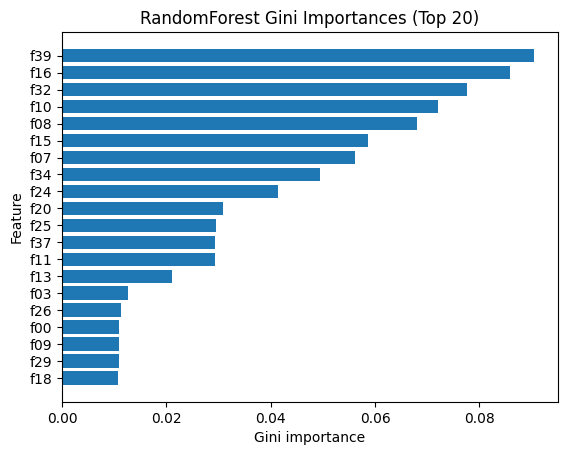

In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # fit only on TRAIN

gini_imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
gini_df = gini_imp.reset_index()
gini_df.columns = ["feature", "importance"]
print("Top 10 features by Gini importance:")
print(gini_df.head(10))

# Plot top 20
plt.figure()
plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("RandomForest Gini Importances (Top 20)")
plt.show()

## 5) Top-k selection by RF Gini importance — validation accuracy curve

Best k on validation (using baseline best params): k=19, val_acc=0.917


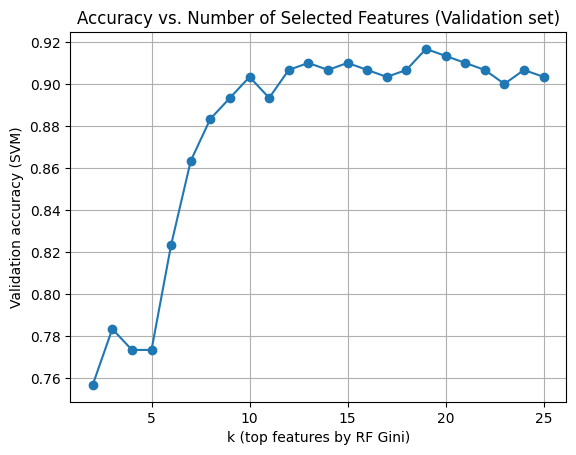

In [ ]:
def accuracy_on_subset(C, gamma, subset_features):
    # subset by feature names
    idx = [np.where(feature_names == f)[0][0] for f in subset_features]
    Xtr = X_train[:, idx]
    Xva = X_val[:, idx]
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)     # train on TRAIN only
    return pipe.score(Xva, y_val)  # accuracy on VALIDATION

# We'll sweep k and, for each k, re-evaluate the best baseline SVM params on the reduced feature set
ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
curve = []

for k in ks:
    subset = gini_df["feature"].head(k).tolist()
    acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
    curve.append(acc_k)

best_k_idx = int(np.argmax(curve))
best_k = ks[best_k_idx]
print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

plt.figure()
plt.plot(ks, curve, marker="o")
plt.xlabel("k (top features by RF Gini)")
plt.ylabel("Validation accuracy (SVM)")
plt.title("Accuracy vs. Number of Selected Features (Validation set)")
plt.grid(True)
plt.show()

## 6) Final model: re-tune SVM on selected features (train→val), then evaluate on TEST

In [ ]:
# Use the best k from the validation curve
best_subset = gini_df["feature"].head(best_k).tolist()
idx = [np.where(feature_names == f)[0][0] for f in best_subset]

Xtr_sel = X_train[:, idx]
Xva_sel = X_val[:, idx]
Xte_sel = X_test[:, idx]

# Manual grid search again but now restricted to the selected features
best_score_sel = -np.inf
best_params_sel = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(Xtr_sel, y_train)      # train on TRAIN
        val_acc = pipe.score(Xva_sel, y_val)  # validate on VAL
        if val_acc > best_score_sel:
            best_score_sel = val_acc
            best_params_sel = {"C": C, "gamma": gamma}

# Train final model on TRAIN+VAL with best params (optional) or just TRAIN; here we keep TRAIN only as per your outline
final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
final_pipe.fit(Xtr_sel, y_train)
test_acc = final_pipe.score(Xte_sel, y_test)

print("Selected features (best k):", best_subset)
print("Best validation accuracy on selected features:", f"{best_score_sel:.3f}", "with", best_params_sel)
print("Test accuracy (selected features, tuned on val):", f"{test_acc:.3f}")

# For comparison: test accuracy with all features using baseline best params
baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
baseline_pipe.fit(X_train, y_train)
test_acc_all = baseline_pipe.score(X_test, y_test)
print("Test accuracy (all features, baseline tuned on val):", f"{test_acc_all:.3f}")

Selected features (best k): ['f39', 'f16', 'f32', 'f10', 'f08', 'f15', 'f07', 'f34', 'f24', 'f20', 'f25', 'f37', 'f11', 'f13', 'f03', 'f26', 'f00', 'f09', 'f29']
Best validation accuracy on selected features: 0.927 with {'C': 100.0, 'gamma': 0.01}
Test accuracy (selected features, tuned on val): 0.937
Test accuracy (all features, baseline tuned on val): 0.877
